# Whole image quality control metric evaluation - Optimization

In this notebook, we will use the outputted QC metrics per image (every z-slice per channel) to start working on developing thresholds using z-score to flag images during CellProfiler processing.
We are loading in the results from the preliminary data (across three patients) to attempt to develop generalizable thresholds.
This data is 3D, so we are decide if it make sense to remove a whole organoid based on if one z-slice fails.

## Blurry image detection

For detecting poor quality images based on blur, we use the feature `PowerLogLogSlope`, where more negative values indicate blurry images.
We first create distribution plots per plates and per channel to evaluate if the distributions across channels are different.
We will use this to determine if we process the data with all channels combined or separately.

## Over-saturated image detection

For detecting poor quality images based on saturation, we use the feature `PercentMaximal`, where higher values means the image contains overly saturated pixels.
We know that this metric is on a scale from 0 to 100, where 100 means that all of the pixels in an image are at the highest pixel intensity based on the intensity distribution of that image.
We will process each channel independently but including all plates together.

We will use a method called `coSMicQC`, which takes a feature of interest and detect outliers based on z-scoring and how far from the mean that outliers will be.

## Import libraries

In [ ]:
import pathlib
import sys

import cosmicqc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from notebook_init_utils import avoid_path_crash_bandicoot, init_notebook

root_dir, in_notebook = init_notebook()

## Set paths and variables

In [ ]:
# Set the threshold for identifying outliers with z-scoring for all metrics (# of standard deviations away from mean)
threshold_z = 2

# Directory for figures to be outputted
figure_dir = pathlib.Path(f"{root_dir}/1.image_quality_control/qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory containing the QC results
qc_results_dir = pathlib.Path(f"{root_dir}/1.image_quality_control/qc_results")

# Directory for output flags for optimization plate
qc_output_dir = pathlib.Path(f"{root_dir}/1.image_quality_control/qc_flag_files")

# Path to Image.csv file for optimization plate
image_csv_path = pathlib.Path(f"{qc_results_dir}/NF0017_qc_results/Image.csv")

# Path to the template pipeline file to update with proper thresholds for flagging
pipeline_path = pathlib.Path(
    f"{root_dir}/1.image_quality_control/pipeline/template_flag_pipeline.cppipe"
)

## Load in QC results for optimization plate

In [3]:
# Define prefixes for columns to select
prefixes = (
    "Metadata",
    "FileName",
    "PathName",
    "ImageQuality_PowerLogLogSlope",
    "ImageQuality_PercentMaximal",
)

# Load only the required columns by filtering columns with specified prefixes
plate_df = pd.read_csv(image_csv_path, usecols=lambda col: col.startswith(prefixes))

# Update technical errors in the metadata
plate_df["Metadata_Plate"] = "NF0017"  # Assign Metadata_Plate
if "Metadata_FOV" in plate_df.columns:
    plate_df = plate_df.rename(
        columns={"Metadata_FOV": "Metadata_Site"}
    )  # Rename column

# Create AGP_conditions by combining AGP LED_power and exposure_time
agp_led_col = "Metadata_AGP_LED_power"
agp_exposure_col = "Metadata_AGP_exposure_time"
if agp_led_col in plate_df.columns and agp_exposure_col in plate_df.columns:
    plate_df["AGP_conditions"] = (
        plate_df[agp_led_col].astype(str) + "-" + plate_df[agp_exposure_col].astype(str)
    )

# Create Mito_conditions by combining Mito LED_power and exposure_time
mito_led_col = "Metadata_Mito_LED_power"
mito_exposure_col = "Metadata_Mito_exposure_time"
if mito_led_col in plate_df.columns and mito_exposure_col in plate_df.columns:
    plate_df["Mito_conditions"] = (
        plate_df[mito_led_col].astype(str)
        + "-"
        + plate_df[mito_exposure_col].astype(str)
    )

# Add a new column combining AGP and Mito conditions in the specified format
plate_df["Unique_conditions"] = (
    "("
    + plate_df["AGP_conditions"]
    + ")"
    + "-"
    + "("
    + plate_df["Mito_conditions"]
    + ")"
)

# Add a new column Metadata_zslice_total which gets the number of rows per Metadata_Plate, Metadata_Well, and Metadata_Site unique combos
plate_df["Metadata_zslice_total"] = plate_df.groupby(
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "AGP_conditions",
        "Mito_conditions",
    ]
)["Metadata_Site"].transform("count")

print(plate_df.shape)
plate_df.head(2)

(1182, 36)


,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,ImageQuality_PercentMaximal_AGP,ImageQuality_PercentMaximal_DNA,ImageQuality_PercentMaximal_ER,ImageQuality_PercentMaximal_Inverted_Brightfield,ImageQuality_PercentMaximal_Mito,...,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_Plate,AGP_conditions,Mito_conditions,Unique_conditions,Metadata_zslice_total
0,C5-1-(10-115)-(24-350)_555_ZS000_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS000_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS000_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS000_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS000_FOV-1.tif,0.000042,0.000042,0.000042,0.454166,0.000042,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
1,C5-1-(10-115)-(24-350)_555_ZS001_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS001_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS001_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS001_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS001_FOV-1.tif,0.000042,0.000042,0.000042,0.454166,0.000042,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17


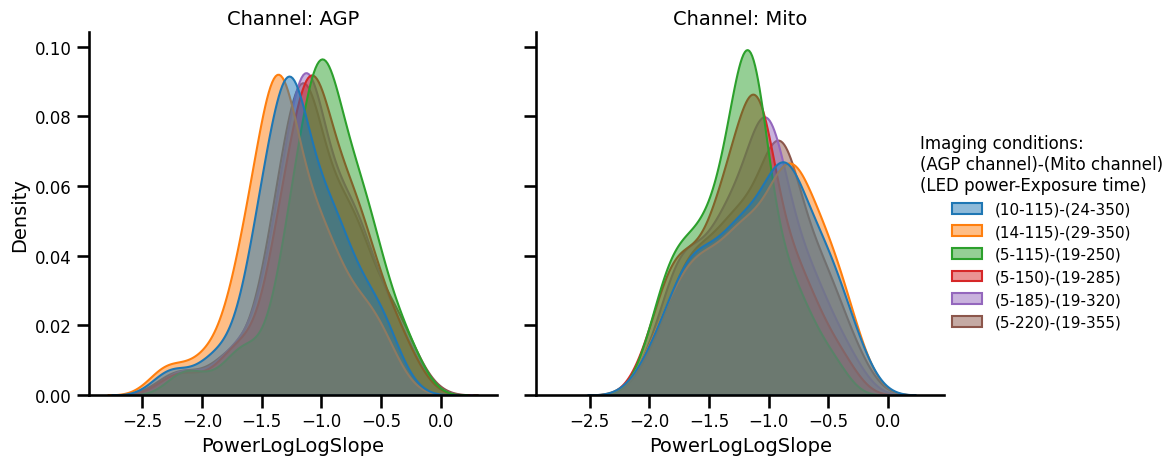

In [4]:
# Set a larger font context for the plot
sns.set_context(
    "talk",
    rc={
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "legend.title_fontsize": 12,
    },
)

# Step 1: Select only the columns containing "PowerLogLogSlope" and keep Unique_conditions
relevant_columns = [col for col in plate_df.columns if "PowerLogLogSlope" in col]
relevant_columns.insert(0, "Unique_conditions")

# Filter the dataframe
filtered_df = plate_df[relevant_columns]

# Step 2: Reshape the dataframe into a long format
long_df = filtered_df.melt(
    id_vars=["Unique_conditions"], var_name="Channel", value_name="PowerLogLogSlope"
)

# Step 3: Clean up the channel names
long_df["Channel"] = long_df["Channel"].str.replace(
    "ImageQuality_PowerLogLogSlope_", ""
)

# Drop rows with missing or non-numeric values
long_df = long_df.dropna(subset=["PowerLogLogSlope"])

# Filter the dataframe to only include "Mito" and "AGP"
long_df = long_df[long_df["Channel"].isin(["Mito", "AGP"])]

# Calculate the average PowerLogLogSlope per channel and condition
avg_slope = (
    long_df.groupby(["Unique_conditions", "Channel"])["PowerLogLogSlope"]
    .mean()
    .reset_index()
)
avg_slope.rename(columns={"PowerLogLogSlope": "Average_PowerLogLogSlope"}, inplace=True)

# Step 4: Create the facet grid
g = sns.displot(
    data=long_df,
    x="PowerLogLogSlope",
    hue="Unique_conditions",
    palette="tab10",  # Let seaborn choose a 6-color palette
    col="Channel",
    kind="kde",
    fill=True,
    alpha=0.5,
)

# Customize the plot
g.set_titles("Channel: {col_name}")
g.set_axis_labels("PowerLogLogSlope", "Density")
g._legend.set_title(
    "Imaging conditions:\n(AGP channel)-(Mito channel)\n(LED power-Exposure time)"
)
g.tight_layout()

# Save the plot
plt.savefig(figure_dir / "optimize_conditions_blur_density_distribution.png", dpi=500)

# Show the plot
plt.show()

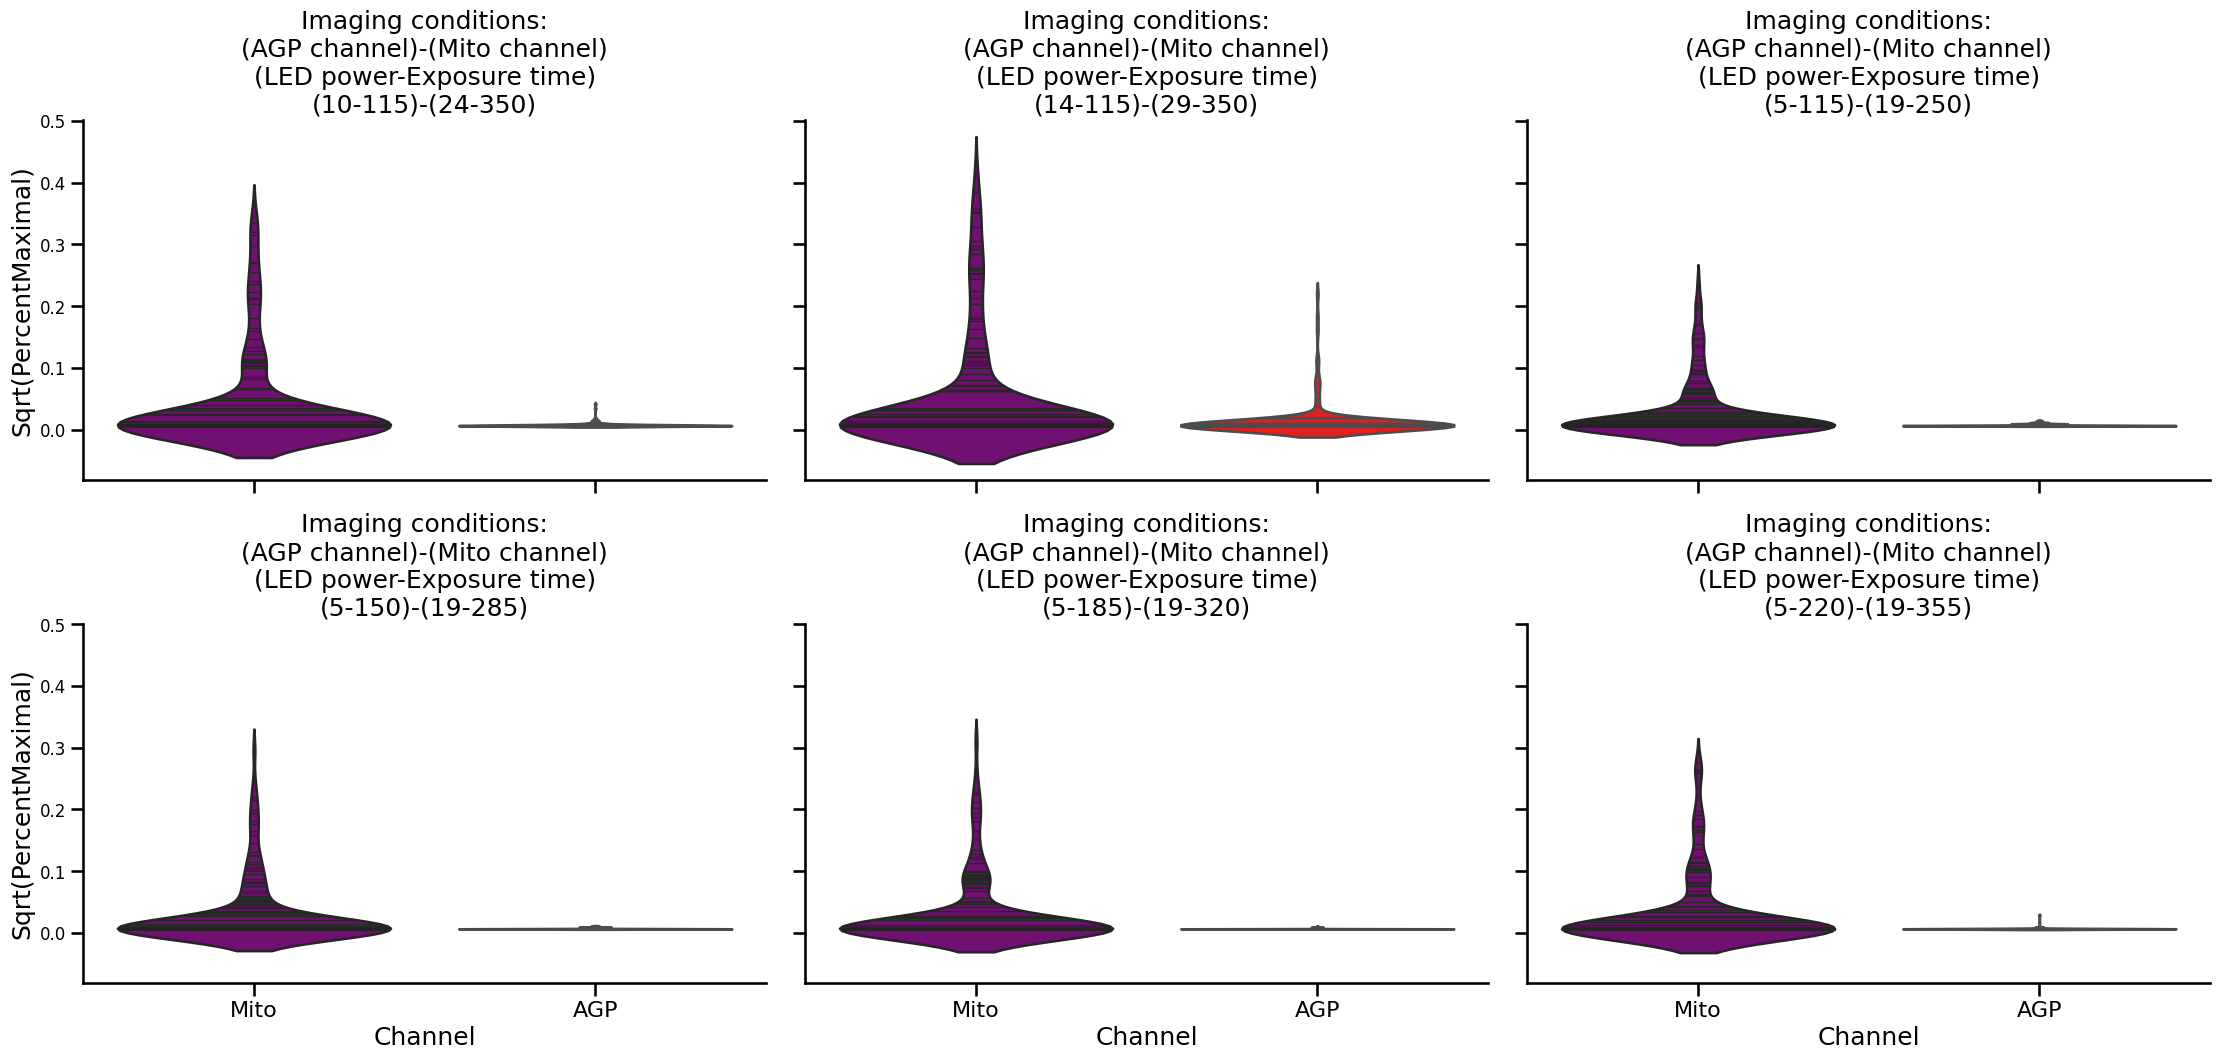

In [5]:
# Step 1: Select only the columns containing "PercentMaximal" and keep Unique_conditions
relevant_columns = [col for col in plate_df.columns if "PercentMaximal" in col]
relevant_columns.insert(0, "Unique_conditions")

# Filter the dataframe
filtered_df = plate_df[relevant_columns]

# Step 2: Reshape the dataframe into a long format
long_df = filtered_df.melt(
    id_vars=["Unique_conditions"], var_name="Channel", value_name="PercentMaximal"
)

# Step 3: Clean up the channel names
long_df["Channel"] = long_df["Channel"].str.replace("ImageQuality_PercentMaximal_", "")

# Drop rows with missing or non-numeric values
long_df = long_df.dropna(subset=["PercentMaximal"])

# Filter the dataframe to only include "Mito" and "AGP"
long_df = long_df[long_df["Channel"].isin(["Mito", "AGP"])]

# Step 4: Apply a square root transformation to PercentMaximal to reduce skewness
long_df["Sqrt_PercentMaximal"] = np.sqrt(long_df["PercentMaximal"])

# Step 5: Set custom colors for Mito (purple) and AGP (red)
channel_colors = {"Mito": "purple", "AGP": "red"}

# Step 6: Create a FacetGrid to facet by Unique_conditions and Channel, with 3 per row
g = sns.FacetGrid(
    long_df,
    col="Unique_conditions",
    hue="Channel",
    height=5,
    aspect=1.5,
    palette=channel_colors,
    col_wrap=3,
)

# Step 7: Plot the violin plot for each facet using the transformed data
g.map(
    sns.violinplot,
    "Channel",
    "Sqrt_PercentMaximal",
    order=["Mito", "AGP"],
    inner="stick",
)

# Adjust titles, labels, and legend
g.set_titles(
    "Imaging conditions:\n(AGP channel)-(Mito channel)\n(LED power-Exposure time)\n{col_name}",
    size=18,
)
g.set_axis_labels("Channel", "Sqrt(PercentMaximal)", size=18)
g.set_xticklabels(size=16)
g.figure.subplots_adjust(hspace=0.4)  # Increase spacing between rows

# Add channel ticks back
g.set(xticks=[0, 1], xticklabels=["Mito", "AGP"])

# Save the plot
plt.savefig(
    figure_dir / "optimize_conditions_saturation_violin_distribution.png", dpi=500
)

plt.show()

## Detect blur and saturation in Mito channel

## Blur outlier detection

In [6]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in plate_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_Mito_outliers = cosmicqc.find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_Mito": -2,
    },
)

pd.DataFrame(blur_Mito_outliers)

blur_Mito_outliers = blur_Mito_outliers.sort_values(
    by="ImageQuality_PowerLogLogSlope_Mito", ascending=True
)

blur_Mito_outliers.head()

Number of outliers: 17 (1.44%)
Outliers Range:
ImageQuality_PowerLogLogSlope_Mito Min: -2.068580639089218
ImageQuality_PowerLogLogSlope_Mito Max: -2.003318475343932


,ImageQuality_PowerLogLogSlope_Mito,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_AGP_LED_power,Metadata_AGP_exposure_time,Metadata_Channel,Metadata_Site,...,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_Plate,AGP_conditions,Mito_conditions,Unique_conditions,Metadata_zslice_total
962,-2.068581,C9-5-(5-115)-(19-250)_555_ZS010_FOV-1.tif,C9-5-(5-115)-(19-250)_TRANS_ZS010_FOV-1.tif,C9-5-(5-115)-(19-250)_405_ZS010_FOV-1.tif,C9-5-(5-115)-(19-250)_488_ZS010_FOV-1.tif,C9-5-(5-115)-(19-250)_640_ZS010_FOV-1.tif,5,115,NaN,5,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,5-115,19-250,(5-115)-(19-250),23
984,-2.063863,C9-5-(5-150)-(19-285)_555_ZS009_FOV-1.tif,C9-5-(5-150)-(19-285)_TRANS_ZS009_FOV-1.tif,C9-5-(5-150)-(19-285)_405_ZS009_FOV-1.tif,C9-5-(5-150)-(19-285)_488_ZS009_FOV-1.tif,C9-5-(5-150)-(19-285)_640_ZS009_FOV-1.tif,5,150,NaN,5,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,5-150,19-285,(5-150)-(19-285),23
961,-2.063416,C9-5-(5-115)-(19-250)_555_ZS009_FOV-1.tif,C9-5-(5-115)-(19-250)_TRANS_ZS009_FOV-1.tif,C9-5-(5-115)-(19-250)_405_ZS009_FOV-1.tif,C9-5-(5-115)-(19-250)_488_ZS009_FOV-1.tif,C9-5-(5-115)-(19-250)_640_ZS009_FOV-1.tif,5,115,NaN,5,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,5-115,19-250,(5-115)-(19-250),23
983,-2.055965,C9-5-(5-150)-(19-285)_555_ZS008_FOV-1.tif,C9-5-(5-150)-(19-285)_TRANS_ZS008_FOV-1.tif,C9-5-(5-150)-(19-285)_405_ZS008_FOV-1.tif,C9-5-(5-150)-(19-285)_488_ZS008_FOV-1.tif,C9-5-(5-150)-(19-285)_640_ZS008_FOV-1.tif,5,150,NaN,5,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,5-150,19-285,(5-150)-(19-285),23
915,-2.050614,C9-5-(10-115)-(24-350)_555_ZS009_FOV-1.tif,C9-5-(10-115)-(24-350)_TRANS_ZS009_FOV-1.tif,C9-5-(10-115)-(24-350)_405_ZS009_FOV-1.tif,C9-5-(10-115)-(24-350)_488_ZS009_FOV-1.tif,C9-5-(10-115)-(24-350)_640_ZS009_FOV-1.tif,10,115,NaN,5,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),23


6


/tmp/ipykernel_2916754/468492934.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1))


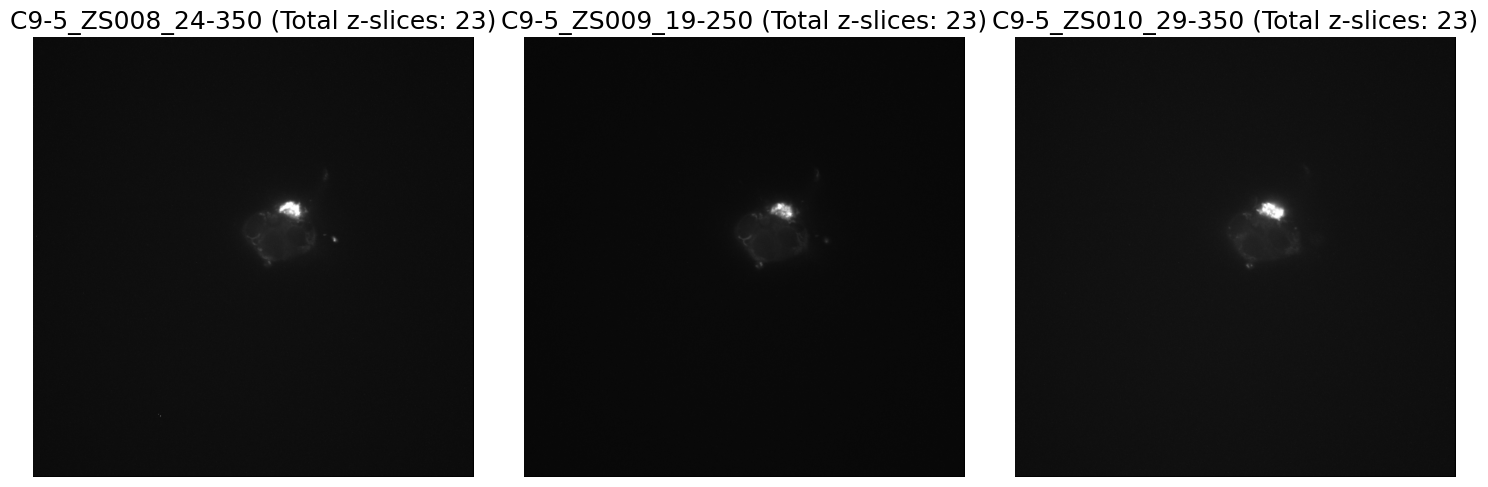

In [7]:
# Combine PathName and FileName columns to construct full paths for Mito
blur_Mito_outliers["Full_Path_Mito"] = (
    blur_Mito_outliers["PathName_Mito"] + "/" + blur_Mito_outliers["FileName_Mito"]
)

# Group by Plate, Well, Site and Conditions to ensure uniqueness
unique_groups = blur_Mito_outliers.groupby(
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "AGP_conditions",
        "Mito_conditions",
    ]
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print(
        "Not enough unique Plate-Well-Site-Conditions combinations for the requested images."
    )
else:
    selected_images = unique_samples.sample(n=3)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(selected_images.itertuples(), start=1):
    image_path = row.Full_Path_Mito
    # Format the metadata title
    metadata_title = f"{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}_{row.Mito_conditions} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Saturation outlier detection

In [8]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in plate_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for Mito channel
saturation_Mito_outliers = cosmicqc.find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_Mito": 6,
    },
)

pd.DataFrame(saturation_Mito_outliers)

saturation_Mito_outliers = saturation_Mito_outliers.sort_values(
    by="ImageQuality_PercentMaximal_Mito", ascending=True
)

saturation_Mito_outliers.head()

Number of outliers: 8 (0.68%)
Outliers Range:
ImageQuality_PercentMaximal_Mito Min: 0.1075078268060724
ImageQuality_PercentMaximal_Mito Max: 0.1706707847058724


,ImageQuality_PercentMaximal_Mito,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_AGP_LED_power,Metadata_AGP_exposure_time,Metadata_Channel,Metadata_Site,...,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_Plate,AGP_conditions,Mito_conditions,Unique_conditions,Metadata_zslice_total
1070,0.107508,C9-6-(14-115)-(29-350)_555_ZS003_FOV-1.tif,C9-6-(14-115)-(29-350)_TRANS_ZS003_FOV-1.tif,C9-6-(14-115)-(29-350)_405_ZS003_FOV-1.tif,C9-6-(14-115)-(29-350)_488_ZS003_FOV-1.tif,C9-6-(14-115)-(29-350)_640_ZS003_FOV-1.tif,14,115,NaN,6,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),23
5,0.112233,C5-1-(10-115)-(24-350)_555_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS005_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
290,0.118984,C8-3-(10-115)-(24-350)_555_ZS002_FOV-1.tif,C8-3-(10-115)-(24-350)_TRANS_ZS002_FOV-1.tif,C8-3-(10-115)-(24-350)_405_ZS002_FOV-1.tif,C8-3-(10-115)-(24-350)_488_ZS002_FOV-1.tif,C8-3-(10-115)-(24-350)_640_ZS002_FOV-1.tif,10,115,NaN,3,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
23,0.122613,C5-1-(14-115)-(29-350)_555_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS006_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17
308,0.123921,C8-3-(14-115)-(29-350)_555_ZS003_FOV-1.tif,C8-3-(14-115)-(29-350)_TRANS_ZS003_FOV-1.tif,C8-3-(14-115)-(29-350)_405_ZS003_FOV-1.tif,C8-3-(14-115)-(29-350)_488_ZS003_FOV-1.tif,C8-3-(14-115)-(29-350)_640_ZS003_FOV-1.tif,14,115,NaN,3,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17


5


/tmp/ipykernel_2916754/901320955.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1))


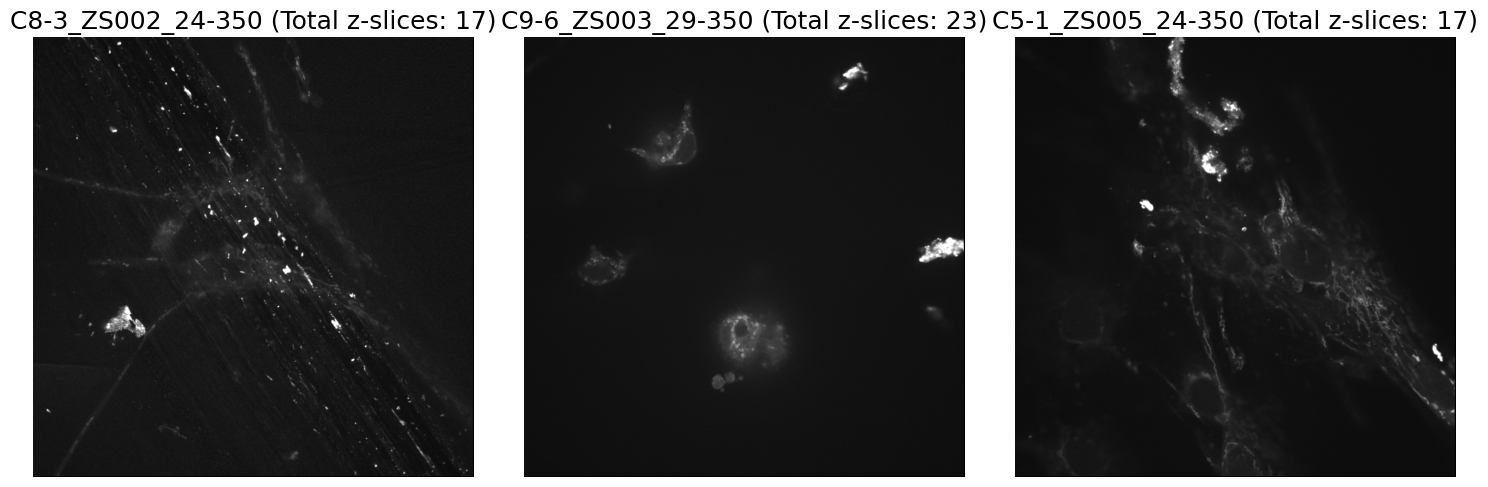

In [9]:
# Combine PathName and FileName columns to construct full paths for Mito
saturation_Mito_outliers["Full_Path_Mito"] = (
    saturation_Mito_outliers["PathName_Mito"]
    + "/"
    + saturation_Mito_outliers["FileName_Mito"]
)

# Group by Plate, Well, Site and Conditions to ensure uniqueness
unique_groups = saturation_Mito_outliers.groupby(
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "AGP_conditions",
        "Mito_conditions",
    ]
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print(
        "Not enough unique Plate-Well-Site-Condition combinations for the requested images."
    )
else:
    selected_images = unique_samples.sample(n=3)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(selected_images.itertuples(), start=1):
    image_path = row.Full_Path_Mito
    # Format the metadata title
    metadata_title = f"{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}_{row.Mito_conditions} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Detect blur in AGP channel

In [10]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in plate_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_agp_outliers = cosmicqc.find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_AGP": -2.25,
    },
)

pd.DataFrame(blur_agp_outliers).head()

Number of outliers: 36 (3.05%)
Outliers Range:
ImageQuality_PowerLogLogSlope_AGP Min: -2.3652157852882603
ImageQuality_PowerLogLogSlope_AGP Max: -2.0502313559870213


,ImageQuality_PowerLogLogSlope_AGP,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_AGP_LED_power,Metadata_AGP_exposure_time,Metadata_Channel,Metadata_Site,...,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_Plate,AGP_conditions,Mito_conditions,Unique_conditions,Metadata_zslice_total
5,-2.085026,C5-1-(10-115)-(24-350)_555_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS005_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS005_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
6,-2.245359,C5-1-(10-115)-(24-350)_555_ZS006_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS006_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS006_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS006_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS006_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
7,-2.242812,C5-1-(10-115)-(24-350)_555_ZS007_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS007_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS007_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS007_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS007_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
8,-2.336353,C5-1-(10-115)-(24-350)_555_ZS008_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS008_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS008_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS008_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS008_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17
9,-2.341019,C5-1-(10-115)-(24-350)_555_ZS009_FOV-1.tif,C5-1-(10-115)-(24-350)_TRANS_ZS009_FOV-1.tif,C5-1-(10-115)-(24-350)_405_ZS009_FOV-1.tif,C5-1-(10-115)-(24-350)_488_ZS009_FOV-1.tif,C5-1-(10-115)-(24-350)_640_ZS009_FOV-1.tif,10,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,10-115,24-350,(10-115)-(24-350),17


6


/tmp/ipykernel_2916754/1049083861.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1))


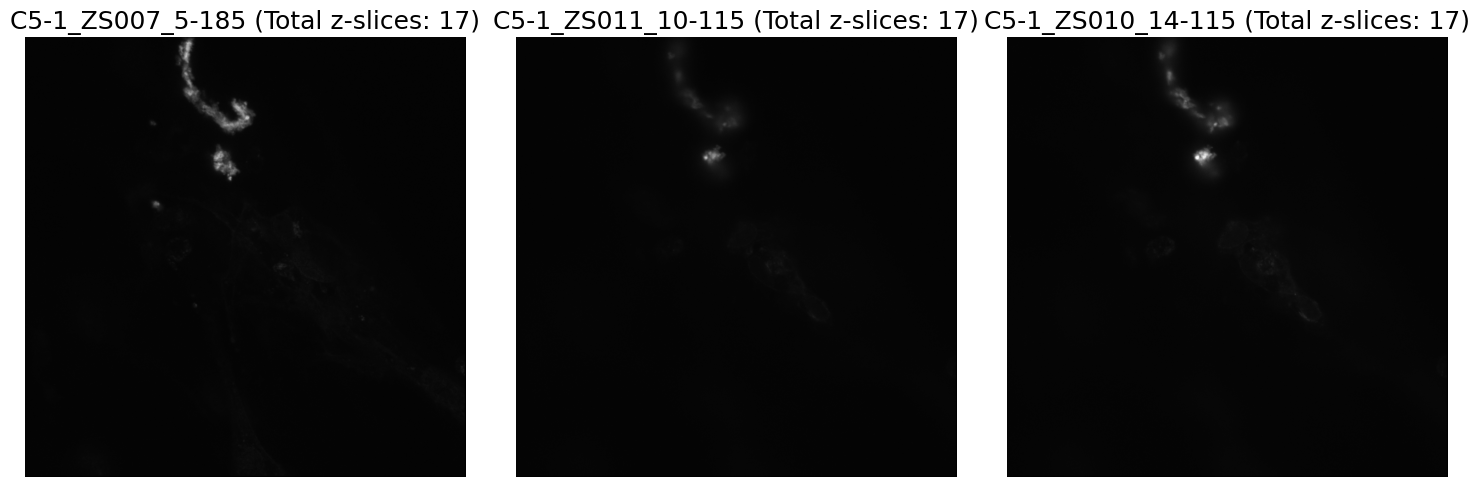

In [11]:
# Combine PathName and FileName columns to construct full paths
blur_agp_outliers["Full_Path_AGP"] = (
    blur_agp_outliers["PathName_AGP"] + "/" + blur_agp_outliers["FileName_AGP"]
)

# Group by Plate, Well, Site and Conditions to ensure uniqueness
unique_groups = blur_agp_outliers.groupby(
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "AGP_conditions",
        "Mito_conditions",
    ]
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print(
        "Not enough unique Plate-Well-Site-Condition combinations for the requested images."
    )
else:
    selected_images = unique_samples.sample(n=3)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_AGP
    # Format the metadata title
    metadata_title = f"{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}_{row.AGP_conditions} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Saturation outlier detection

In [12]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in plate_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for AGP channel
saturation_agp_outliers = cosmicqc.find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_AGP": 2,
    },
)

pd.DataFrame(saturation_agp_outliers).head()

Number of outliers: 9 (0.76%)
Outliers Range:
ImageQuality_PercentMaximal_AGP Min: 0.0045568466621098
ImageQuality_PercentMaximal_AGP Max: 0.0481422411246972


,ImageQuality_PercentMaximal_AGP,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_AGP_LED_power,Metadata_AGP_exposure_time,Metadata_Channel,Metadata_Site,...,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_Plate,AGP_conditions,Mito_conditions,Unique_conditions,Metadata_zslice_total
21,0.004557,C5-1-(14-115)-(29-350)_555_ZS004_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS004_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS004_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS004_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS004_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17
22,0.033543,C5-1-(14-115)-(29-350)_555_ZS005_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS005_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS005_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS005_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS005_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17
23,0.048142,C5-1-(14-115)-(29-350)_555_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS006_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS006_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17
24,0.025696,C5-1-(14-115)-(29-350)_555_ZS007_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS007_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS007_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS007_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS007_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17
25,0.013291,C5-1-(14-115)-(29-350)_555_ZS008_FOV-1.tif,C5-1-(14-115)-(29-350)_TRANS_ZS008_FOV-1.tif,C5-1-(14-115)-(29-350)_405_ZS008_FOV-1.tif,C5-1-(14-115)-(29-350)_488_ZS008_FOV-1.tif,C5-1-(14-115)-(29-350)_640_ZS008_FOV-1.tif,14,115,NaN,1,...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,NF0017,14-115,29-350,(14-115)-(29-350),17


3


/tmp/ipykernel_2916754/3401217245.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1))


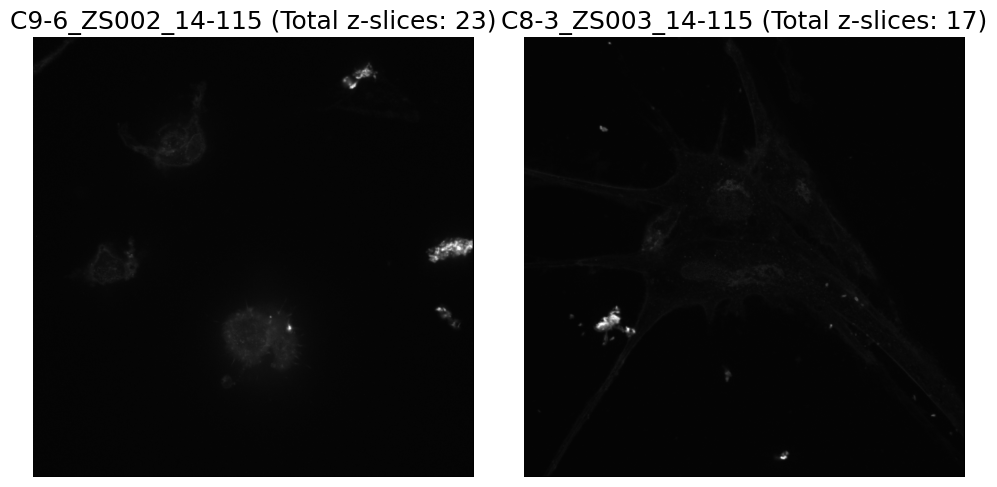

In [13]:
# Combine PathName and FileName columns to construct full paths
saturation_agp_outliers["Full_Path_AGP"] = (
    saturation_agp_outliers["PathName_AGP"]
    + "/"
    + saturation_agp_outliers["FileName_AGP"]
)

# Group by Plate, Well, Site and Conditions to ensure uniqueness
unique_groups = saturation_agp_outliers.groupby(
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "AGP_conditions",
        "Mito_conditions",
    ]
)
print(len(unique_groups))


# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 2 unique images
if len(unique_samples) < 2:
    print(
        "Not enough unique Plate-Well-Site-Condition combinations for the requested images."
    )
else:
    selected_images = unique_samples.sample(n=2)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_AGP
    # Format the metadata title
    metadata_title = f"{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}_{row.AGP_conditions} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Create dataframe for each plate/well/site/condition combos and boolean for pass/fail blur per channel

In [14]:
# Combine all blur outliers dataframes into a single dataframe
blur_outliers = pd.concat(
    [
        blur_Mito_outliers,
        blur_agp_outliers,
    ],
    keys=["Mito", "AGP"],
    names=["Channel"],
).reset_index(level="Channel")

# Create a new dataframe with only Metadata_Plate, Metadata_Well, Metadata_Site, and Metadata_Zslice columns to assign blur flags
blur_outliers_per_zslice = plate_df[
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "Metadata_Zslice",
        "AGP_conditions",
        "Mito_conditions",
    ]
].drop_duplicates()

# Initialize columns for each channel with False
for channel in ["Mito", "AGP"]:
    blur_outliers_per_zslice[f"Blurry_{channel}"] = False

# Flag the combos for blur detection
for channel in ["Mito", "AGP"]:
    blur_combos = blur_outliers[blur_outliers["Channel"] == channel][
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_Site",
            "Metadata_Zslice",
            "AGP_conditions",
            "Mito_conditions",
        ]
    ].drop_duplicates()
    blur_outliers_per_zslice.loc[
        blur_outliers_per_zslice.set_index(
            [
                "Metadata_Plate",
                "Metadata_Well",
                "Metadata_Site",
                "Metadata_Zslice",
                "AGP_conditions",
                "Mito_conditions",
            ]
        ).index.isin(
            blur_combos.set_index(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_Site",
                    "Metadata_Zslice",
                    "AGP_conditions",
                    "Mito_conditions",
                ]
            ).index
        ),
        f"Blurry_{channel}",
    ] = True

# Reset the index on the unique combos dataframe
blur_outliers_per_zslice = blur_outliers_per_zslice.reset_index(drop=True)

# Print the number of rows with at least one Blurry column set to True
num_blurry_rows = (
    blur_outliers_per_zslice.loc[:, "Blurry_Mito":"Blurry_AGP"].any(axis=1).sum()
)
print(
    f"Number of z-slices across all organoids detected as poor quality due to blur (in any channel): {num_blurry_rows}"
)

# Calculate and print the percentage of organoids detected as containing blur
percentage_blurry = (num_blurry_rows / len(blur_outliers_per_zslice)) * 100
print(
    f"Percentage of z-slices detected as poor quality due to blur: {percentage_blurry:.2f}%"
)

# # Display the resulting dataframe
print(blur_outliers_per_zslice.shape)
blur_outliers_per_zslice.head()

Number of z-slices across all organoids detected as poor quality due to blur (in any channel): 53
Percentage of z-slices detected as poor quality due to blur: 4.48%
(1182, 8)


,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,AGP_conditions,Mito_conditions,Blurry_Mito,Blurry_AGP
0,NF0017,C5,1,ZS000,10-115,24-350,False,False
1,NF0017,C5,1,ZS001,10-115,24-350,False,False
2,NF0017,C5,1,ZS002,10-115,24-350,False,False
3,NF0017,C5,1,ZS003,10-115,24-350,False,False
4,NF0017,C5,1,ZS004,10-115,24-350,False,False


## Create parquet file with each plate/well/site/condition combos and boolean for pass/fail per channel adding saturation to the already generated blur dataframe

In [15]:
# Combine all saturation outliers dataframes into a single dataframe
saturation_outliers = pd.concat(
    [
        saturation_Mito_outliers,
        saturation_agp_outliers,
    ],
    keys=["Mito", "AGP"],
    names=["Channel"],
).reset_index(level="Channel")

# Create a new dataframe with unique combinations of Metadata_Plate, Metadata_Well, Metadata_Site, and Metadata_ZSlice and Conditions
saturation_outliers_per_zslice = plate_df[
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "Metadata_Zslice",
        "AGP_conditions",
        "Mito_conditions",
    ]
].drop_duplicates()

# Initialize columns for each channel with False
for channel in ["Mito", "AGP"]:
    saturation_outliers_per_zslice[f"Saturated_{channel}"] = False

# Flag the combos for saturation detection
for channel in ["Mito", "AGP"]:
    saturation_combos = saturation_outliers[saturation_outliers["Channel"] == channel][
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_Site",
            "Metadata_Zslice",
            "AGP_conditions",
            "Mito_conditions",
        ]
    ].drop_duplicates()
    saturation_outliers_per_zslice.loc[
        saturation_outliers_per_zslice.set_index(
            [
                "Metadata_Plate",
                "Metadata_Well",
                "Metadata_Site",
                "Metadata_Zslice",
                "AGP_conditions",
                "Mito_conditions",
            ]
        ).index.isin(
            saturation_combos.set_index(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_Site",
                    "Metadata_Zslice",
                    "AGP_conditions",
                    "Mito_conditions",
                ]
            ).index
        ),
        f"Saturated_{channel}",
    ] = True

# Reset the index on the unique combos dataframe
saturation_outliers_per_zslice = saturation_outliers_per_zslice.reset_index(drop=True)

# Merge the new Saturated_ columns onto the existing dataframe
merged_qc_results = blur_outliers_per_zslice.merge(
    saturation_outliers_per_zslice,
    on=[
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "Metadata_Zslice",
        "AGP_conditions",
        "Mito_conditions",
    ],
    how="left",
)

# Save the qc outliers per zslice dataframe to a parquet file
merged_qc_results.to_parquet(qc_output_dir / "NF0017_qc_flags.parquet")

# Print the number of rows with at least one Saturated column set to True
num_saturated_rows = (
    saturation_outliers_per_zslice.loc[:, "Saturated_Mito":"Saturated_AGP"]
    .any(axis=1)
    .sum()
)
print(
    f"Number of z-slices across all organoids detected as poor quality due to saturation (in any channel): {num_saturated_rows}"
)

# Calculate and print the percentage of organoids detected as containing saturation
percentage_saturated = (num_saturated_rows / len(saturation_outliers_per_zslice)) * 100
print(
    f"Percentage of z-slices detected as poor quality due to saturation: {percentage_saturated:.2f}%"
)

# Print the shape of the merged dataframe
print(merged_qc_results.shape)

# Display the first few rows of the merged dataframe
merged_qc_results.head()

Number of z-slices across all organoids detected as poor quality due to saturation (in any channel): 13
Percentage of z-slices detected as poor quality due to saturation: 1.10%
(1182, 10)


,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,AGP_conditions,Mito_conditions,Blurry_Mito,Blurry_AGP,Saturated_Mito,Saturated_AGP
0,NF0017,C5,1,ZS000,10-115,24-350,False,False,False,False
1,NF0017,C5,1,ZS001,10-115,24-350,False,False,False,False
2,NF0017,C5,1,ZS002,10-115,24-350,False,False,False,False
3,NF0017,C5,1,ZS003,10-115,24-350,False,False,False,False
4,NF0017,C5,1,ZS004,10-115,24-350,False,False,False,False
